# Compute custom scaling constants and exponents
This notebook serves as test file while I'm implementing a routine to compute scaling constants and exponent for a given set of GlacierDirectories.

In [1]:
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from oggm import cfg, workflow, utils

In [3]:
cfg.initialize()

2020-10-11 14:51:25: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2020-10-11 14:51:25: oggm.cfg: Multiprocessing switched ON according to the parameter file.
2020-10-11 14:51:25: oggm.cfg: Multiprocessing: using all available processors (N=4)
2020-10-11 14:51:25: oggm.utils: Checking the download verification file checksum...


In [4]:
cfg.PATHS['working_dir'] = '/Users/oberrauch/work/master/working_directories/equilibrium_wdir'

In [11]:
gdirs = workflow.init_glacier_directories()

2020-10-11 14:52:22: oggm.workflow: init_glacier_directories by parsing all available folders (this takes time: if possible, provide rgidf instead).


In [12]:
glacier_stats = workflow.execute_entity_task(utils.glacier_statistics, gdirs)

2020-10-11 14:52:50: oggm.workflow: Execute entity task glacier_statistics on 56 glaciers


In [25]:
# extract glacier geometries
length = np.array([gs.get('longuest_centerline_km', np.NaN) * 1e3
          for gs in glacier_stats])
area = np.array([gs.get('rgi_area_km2', np.NaN) * 1e6 for gs in glacier_stats])
volume = np.array([gs.get('inv_volume_km3', np.NaN) * 1e9 for gs in glacier_stats])

In [27]:
# remove non finite values
idx_finite = np.isfinite(length) & np.isfinite(area) & np.isfinite(volume)
length = length[idx_finite]
area = area[idx_finite]
volume = volume[idx_finite]

**Visualization**

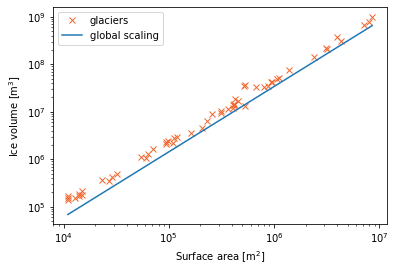

In [28]:
# V/A scatter plot for glaciers
plt.loglog(area, volume, ls='None', marker='x', color='#f3672d', label='glaciers')
# draw scaling relation ship
x = np.sort(area)
c = cfg.PARAMS['vas_c_area_m2']
gamma = cfg.PARAMS['vas_gamma_area']
plt.plot(x, c*x**gamma, ls='-', label='global scaling')
plt.xlabel('Surface area [m$^2$]')
plt.ylabel('Ice volume [m$^3$]')
plt.legend()

**Linear Regression**

In [29]:
# import linear model
from sklearn.linear_model import LinearRegression

In [30]:
# use logartithmic area and volume as x and y values
lm_x = np.log(area).reshape(-1, 1)
lm_y = np.log(volume)
# define model and fit curve
lin_mod = LinearRegression(fit_intercept=True)
lin_mod.fit(lm_x, lm_y)
# compute r-squared
r_sq = lin_mod.score(lm_x, lm_y)
# print results
print('Linear regression\n-----------------')
print(f'r-squared: {r_sq:.3f}')
print(f'intercept: {lin_mod.intercept_:.3f}')
print(f'slope: {lin_mod.coef_[0]:.3f}')

Linear regression
-----------------
r-squared: 0.996
intercept: -0.488
slope: 1.316


Slope and intercept of the linear model correspond to the log-log space. Hence, the results must be "translated"...

In [31]:
# get scaling constant and exponent from linear model
gamma_lm = lin_mod.coef_[0]
c_lm = np.exp(lin_mod.intercept_)
print('Scaling law from linear regression\n----------------------------------')
print(f'V = {c_lm:.3f} S**{gamma_lm:.3f}')

Scaling law from linear regression
----------------------------------
V = 0.614 S**1.316


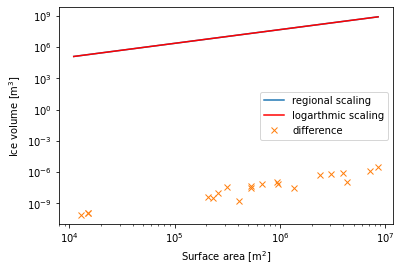

In [32]:
# compare to linear to log scaling law
# plt.plot(area, volume, ls='None', marker='o', label='glaciers')
plt.loglog(x, c_lm * x**gamma_lm, marker='None', label='regional scaling')
plt.plot(x, np.exp(np.log(x)*lin_mod.coef_[0] + lin_mod.intercept_), 'r-', label='logarthmic scaling')
plt.plot(x, (c_lm * x**gamma_lm) - np.exp(np.log(x)*lin_mod.coef_[0] + lin_mod.intercept_),
           marker='x', label='difference', ls='None')
plt.xlabel('Surface area [m$^2$]')
plt.ylabel('Ice volume [m$^3$]')
plt.legend()

My calculations seem to be right (after I found my error 😅). The differences in the range of 10$^{-6}$ to 10$^{-9}$ m$^3$ are of numerical nature

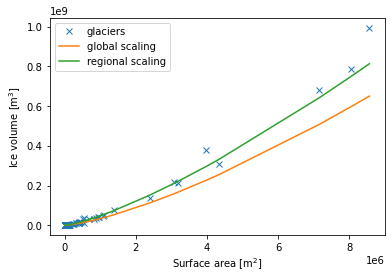

In [33]:
# V/A scatter plot for glaciers
plt.plot(area, volume, ls='None', marker='x', label='glaciers')
# draw scaling relationship
plt.plot(x, c*x**gamma, ls='-', label='global scaling')
plt.plot(x, c_lm*x**gamma_lm, ls='-', label='regional scaling')
plt.xlabel('Surface area [m$^2$]')
plt.ylabel('Ice volume [m$^3$]')
plt.legend()

However, the scaling exponent has a physical basis and shall be fixed. Hereafter I'm estimating the scaling constant for a fixed scaling exponent (slope in the log-log space) of 1.375.

In [34]:
# compute average of single scaling constants
# by solving the scaling realtion for c
c_avg = np.mean(volume/area**gamma)
c_avg

0.3016498216903299

Compute difference between true volumes and predicted volumes, and fit a line with slope 1 to get the intercept

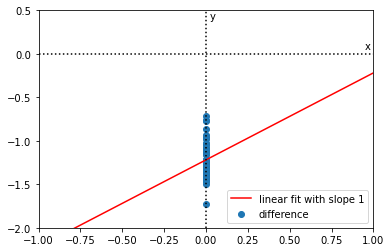

In [35]:
plt.scatter(np.zeros(lm_y.shape), lm_y-gamma*lm_x.flatten(), label='difference')
plt.plot([-1,1],np.array([-1,1])-1.219, 'r-', label='linear fit with slope 1')
plt.axhline(0, ls=':', c='k')
plt.axvline(0, ls=':', c='k')
plt.text(0.95, 0.05,'x')
plt.text(0.02, 0.4,'y')
plt.ylim([-2, 0.5])
plt.xlim([-1, 1])
plt.legend(loc=4)

In [36]:
# compute intercept as mean of differences
intercept = np.mean(lm_y-gamma*lm_x.flatten())
intercept

-1.218864590857477

Test validity of my assumption with an actual linear regression

In [37]:
# use logartithmic area and volume as x and y values
lm_x = np.zeros(area.shape).reshape(-1, 1)
lm_y = np.log(volume) - gamma * np.log(area)
# define model and fit curve
lin_mod = LinearRegression(fit_intercept=True)
lin_mod.fit(lm_x, lm_y)
# compute r-squared
r_sq = lin_mod.score(lm_x, lm_y)
# print results
print('Linear regression\n-----------------')
print(f'r-squared: {r_sq:.3f}')
print(f'intercept: {lin_mod.intercept_:.16f}')
print(f'slope: {lin_mod.coef_[0]:.3f}')

Linear regression
-----------------
r-squared: 0.000
intercept: -1.2188645908574769
slope: 0.000


Seems legit, now compute $r^2$

In [43]:
from sklearn.metrics import r2_score
r2 = r2_score(np.log(volume), gamma*np.log(area)+intercept)
r2

0.993537073392653

Visualize

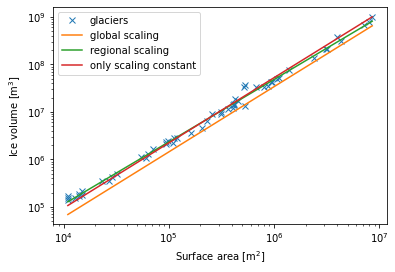

In [44]:
# V/A scatter plot for glaciers
plt.plot(area, volume, ls='None', marker='x', label='glaciers')
# draw scaling relationship
plt.loglog(x, c*x**gamma, ls='-', label='global scaling')
plt.plot(x, c_lm*x**gamma_lm, ls='-', label='regional scaling')
plt.plot(x, np.exp(intercept)*x**gamma, ls='-', label='only scaling constant')
plt.xlabel('Surface area [m$^2$]')
plt.ylabel('Ice volume [m$^3$]')
plt.legend()

The following part is not curated, so "Abandon all hope, ye who enter here."

Test my routine

In [403]:
import importlib

In [401]:
import oggm_vas as vascaling

In [407]:
glacier_stats = workflow.execute_entity_task(utils.glacier_statistics, gdirs)

2020-09-23 18:00:51: oggm.workflow: Execute entity task glacier_statistics on 54 glaciers


In [446]:
importlib.reload(vascaling)
vascaling.get_scaling_constants(gdirs)

AttributeError: 'list' object has no attribute 'get_task_status'

In [423]:
np.exp([0.932897644492324, -1.218864590857477])

array([2.54186393, 0.29556556])

In [424]:
2.54186393*(glacier_stats[0]['longuest_centerline_km']*1e3)**cfg.PARAMS['vas_q_length']/((glacier_stats[0]['rgi_area_km2']*1e6)**cfg.PARAMS['vas_gamma_area'])

0.23710847111774527

In [ ]:
scaling_const_list = [(1.5038582086557708, 0.24399290770672957)]  # HEF
scaling_const_list.append((4.5507, 0.191))  # Global

In [429]:
for i, gs in enumerate(glacier_stats):
    if gs['rgi_id'] == 'RGI60-11.00897':
        print(i)

35


In [444]:
l = glacier_stats[35]['longuest_centerline_km']*1e3
a = glacier_stats[35]['rgi_area_km2']*1e6
v = glacier_stats[35]['inv_volume_km3']*1e9

In [439]:
l = length.mean()
a = area.mean()
v = volume.mean()

In [440]:
v/(a**gamma)

0.43371560550898725

In [436]:
v/(l**cfg.PARAMS['vas_q_length'])

1.555450648460997

In [443]:
(a**gamma)/(l**cfg.PARAMS['vas_q_length'])*0.29556556

5.961741470086434

In [3]:
cfg.initialize()
cfg.PATHS['working_dir'] = '/Users/oberrauch/work/master/working_directories/scaling_params/'
gdirs = workflow.init_glacier_directories()

2020-09-24 10:25:29: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2020-09-24 10:25:29: oggm.cfg: Multiprocessing switched ON according to the parameter file.
2020-09-24 10:25:29: oggm.cfg: Multiprocessing: using all available processors (N=4)
2020-09-24 10:25:29: oggm.utils: Checking the download verification file checksum...
2020-09-24 10:25:30: oggm.workflow: init_glacier_directories by parsing all available folders (this takes time: if possible, provide rgidf instead).


In [5]:
glacier_stats = workflow.execute_entity_task(utils.glacier_statistics, gdirs)

2020-09-24 10:26:22: oggm.workflow: Execute entity task glacier_statistics on 64 glaciers
2020-09-24 10:26:22: oggm.utils: (RGI60-11.00073) glacier_statistics
2020-09-24 10:26:22: oggm.utils: (RGI60-11.00080) glacier_statistics
2020-09-24 10:26:22: oggm.utils: (RGI60-11.00012) glacier_statistics
2020-09-24 10:26:22: oggm.utils: (RGI60-11.00002) glacier_statistics
2020-09-24 10:26:23: oggm.utils: (RGI60-11.00106) glacier_statistics2020-09-24 10:26:23: oggm.utils: (RGI60-11.00190) glacier_statistics

2020-09-24 10:26:23: oggm.utils: (RGI60-11.00251) glacier_statistics
2020-09-24 10:26:23: oggm.utils: (RGI60-11.00289) glacier_statistics
2020-09-24 10:26:24: oggm.utils: (RGI60-11.00300) glacier_statistics
2020-09-24 10:26:24: oggm.utils: (RGI60-11.00603) glacier_statistics
2020-09-24 10:26:24: oggm.utils: (RGI60-11.00619) glacier_statistics
2020-09-24 10:26:24: oggm.utils: (RGI60-11.00638) glacier_statistics
2020-09-24 10:26:24: oggm.utils: (RGI60-11.00647) glacier_statistics
2020-09-24 10

In [56]:
# get glacier geometries
rgi_id = [gs.get('rgi_id', np.NaN) for gs in glacier_stats]
length = [gs.get('longuest_centerline_km', np.NaN)*1e3 for gs in glacier_stats]
area = [gs.get('rgi_area_km2', np.NaN)*1e6 for gs in glacier_stats]
volume = [gs.get('inv_volume_km3', np.NaN)*1e9 for gs in glacier_stats]

In [62]:
# create DataFrame
df = pd.DataFrame({'length': length, 'area': area, 'volume': volume},
                  index=pd.Index(rgi_id, name='rgi_id'))
# drop glaciers where one of the geometries is missing
df = df.dropna()

In [63]:
np.exp(np.mean(np.log(df.volume) - cfg.PARAMS['vas_q_length'] * np.log(df.length)))

3.3907554063667713

In [64]:
np.exp(np.mean(np.log(df.volume) - cfg.PARAMS['vas_gamma_area'] * np.log(df.area)))

0.2828969812133208

In [8]:
import oggm_vas

In [75]:
import importlib

In [76]:
importlib.reload(oggm_vas)

<module 'oggm_vas' from '/Users/oberrauch/oggm-vas/oggm_vas/__init__.py'>

In [18]:
tmp = {'tmp': {'c_l': 2.541863934766808, 'c_a': 0.2955655643252947}, 'asdf': {'c_l': 2.541863934766808, 'c_a': 0.2955655643252947}}

In [19]:
import json

In [20]:
tmp_json = json.dumps(tmp)
f = open('tmp.json', 'w')
f.write(tmp_json)
f.close()

In [30]:
f = open('tmp.json')
asdf = f.read()

In [36]:
import json

In [122]:
tmp = json.load(open('/Users/oberrauch/work/master/data/scaling_params/scaling_params.json'))
tmp

{'const_only': {'c_l': 1.8054161530060988, 'c_a': 0.25011939131456845},
 'const_expo': {'c_l': 0.24422551484811786,
  'c_a': 0.1174364450731111,
  'q': 2.5169432018343123,
  'gamma': 1.4405359898536096,
  'r_sq_l': 0.9452045956477748,
  'r_sq_a': 0.9805846817427352}}

In [131]:
list(tmp['const_only'].values())

In [138]:
tuple(list(tmp['const_expo'].values())[:4])

(0.24422551484811786,
 0.1174364450731111,
 2.5169432018343123,
 1.4405359898536096)

In [140]:
cfg.initialize()

2020-09-25 13:05:45: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2020-09-25 13:05:45: oggm.cfg: Multiprocessing switched ON according to the parameter file.
2020-09-25 13:05:45: oggm.cfg: Multiprocessing: using all available processors (N=4)


In [142]:
cfg.PARAMS['vas_c_area_m2']

0.191

In [85]:
scaling_constants=[(4.5507, 0.191), (123123, 975)]
scaling_exponents=[(2.2, 1.375)]
time_scale_factors=[1, 100]

In [86]:
# limit parameters to 3 decimal points
#
# assure that scaling params are handled as tuples (pairs)
scaling_constants_list = np.zeros(len(scaling_constants), dtype=object)
scaling_constants_list[:] = scaling_constants
scaling_exponents_list = np.zeros(len(scaling_exponents), dtype=object)
scaling_exponents_list[:] = scaling_exponents
# combine scaling constants, scaling exponents and time scale factor
# into one iterable array
sensitivity_params = np.array(np.meshgrid(scaling_constants_list,
                                          scaling_exponents_list,
                                          time_scale_factors)).T
sensitivity_params = (sensitivity_params
                      .reshape(-1, sensitivity_params.shape[-1]))

In [97]:
def sensitivity_run_vas(rgi_ids, use_random_mb=False, use_mean=False,
                        path=True, temp_bias=0, tstar=None,
                        use_default_tstar=True, use_bias_for_run=True,
                        scaling_constants=[(4.5507, 0.191)],
                        scaling_exponents=[(2.2, 1.375)],
                        time_scale_factors=[1],
                        suffixes=['default'], **kwargs):
    """ The routine runs all steps for the equilibrium experiments using the
    volume/area scaling model (cf. `equilibrium_run_vas`) but for only one
    given temperature bias. However, it is possible to supply a list of
    sensitivity parameters (the scaling constants, and time scale factor) to
    alter the model behavior.
    - OGGM preprocessing, including initialization, GIS tasks, climate tasks and
      massbalance tasks.
    - Run model for all glaciers with constant (or random) massbalance model
      over 3000 years (default value).
    - Process the model output dataset(s), i.e. normalization, average/sum, ...

    The final dataset containing all results is returned. Given a path is is
    also stored to file.

    Parameters
    ----------
    rgi_ids: array-like
        List of RGI IDs for which the equilibrium experiments are performed.
    use_random_mb: bool, optional, default=True
        Choose between random massbalance model and constant massbalance model.
    use_mean: bool, optional, default=False
        Choose between the mean or summation over all glaciers
    path: bool or str, optional, default=True
        If a path is given (or True), the resulting dataset is stored to file.
    temp_bias: float, optional, default=0
        Temperature bias (degC) for the mass balance model.
    sensitivity_constants: multi-dimensional array-like, optional,
        default=[(4.5507, 0.191)]
        List containing the scaling constants for length and area scaling as
        tuples
    sensitivity_params: multi-dimensional array-like, optional,
        default=[(2.2, 1.375)]
        List containing the scaling exponents for length and area scaling as
        tuples
    suffixes: array-like, optional, default=['default']
        Descriptive suffixes corresponding to the given sensitivity params
    tstar: float, optional, default=None
        'Equilibrium year' used for the mass balance calibration.
    use_default_tstar: bool, optional, default=True
        Flag deciding whether or not to compute mustar from given from reference
        table. Overridden by a given tstar.
    use_bias_for_run: bool, optional, default=True
        Flag deciding whether or not to use the mass balance residual.
    kwargs:
        Additional key word arguments for the `run_random_climate` or
        `run_constant_climate` routines of the vascaling module.

    Returns
    -------
    Dataset containing yearly values of all glacier geometries.

    """
    # assert correct output file suffixes for temp biases
    if len(scaling_constants) * len(scaling_constants) \
            * len(time_scale_factors) != len(suffixes):
        raise RuntimeError("Each given combination of scaling parameters and "
                           "time scale factor must have its corresponding"
                           "suffix.")

    # OGGM preprocessing
    # ------------------

    # compute RGI region and version from RGI IDs
    # assuming all they are all the same
    rgi_region = (rgi_ids[0].split('-')[-1]).split('.')[0]
    rgi_version = (rgi_ids[0].split('-')[0])[-2:-1]

    # load default parameter file
    cfg.initialize()

    # get environmental variables for working and output directories
    WORKING_DIR = os.environ["WORKDIR"]
    OUTPUT_DIR = os.environ["OUTDIR"]
    # create working directory
    utils.mkdir(WORKING_DIR)
    # set path to working directory
    cfg.PATHS['working_dir'] = WORKING_DIR
    # set RGI version and region
    cfg.PARAMS['rgi_version'] = rgi_version
    # define how many grid points to use around the glacier,
    # if you expect the glacier to grow large use a larger border
    cfg.PARAMS['border'] = 120
    # we use HistAlp climate data
    cfg.PARAMS['baseline_climate'] = 'HISTALP'
    # set the mb hyper parameters accordingly
    cfg.PARAMS['prcp_scaling_factor'] = 1.75
    cfg.PARAMS['temp_melt'] = -1.75
    # the bias is defined to be zero during the calibration process,
    # which is why we don't use it here to reproduce the results
    cfg.PARAMS['use_bias_for_run'] = use_bias_for_run

    # read RGI entry for the glaciers as DataFrame
    # containing the outline area as shapefile
    rgidf = utils.get_rgi_glacier_entities(rgi_ids)

    # get and set path to intersect shapefile
    intersects_db = utils.get_rgi_intersects_region_file(region=rgi_region)
    cfg.set_intersects_db(intersects_db)

    # sort by area for more efficient parallel computing
    rgidf = rgidf.sort_values('Area', ascending=False)
    cfg.PARAMS['use_multiprocessing'] = True
    # operational run, all glaciers should run
    cfg.PARAMS['continue_on_error'] = True

    # initialize the GlacierDirectory
    gdirs = workflow.init_glacier_directories(rgidf, reset=False, force=True)

    # define the local grid and glacier mask
    workflow.execute_entity_task(gis.define_glacier_region, gdirs)
    workflow.execute_entity_task(gis.glacier_masks, gdirs)
    # process the given climate file
    workflow.execute_entity_task(climate.process_climate_data, gdirs)
    # compute local t* and the corresponding mu*
    if tstar or use_default_tstar:
        # compute mustar from given tstar or reference table
        workflow.execute_entity_task(vascaling.local_t_star, gdirs, tstar=tstar, bias=0)
    else:
        # compute mustar from the reference table for the flowline model
        # RGI v6 and HISTALP baseline climate
        ref_df = pd.read_csv(utils.get_demo_file('oggm_ref_tstars_rgi6_histalp.csv'))
        workflow.execute_entity_task(vascaling.local_t_star, gdirs, ref_df=ref_df)

    # Run model with constant/random mass balance model
    # -------------------------------------------------

    # use t* as center year, even if specified differently
    kwargs['y0'] = tstar
    # run for 3000 years if not specified otherwise
    kwargs.setdefault('nyears', 3000)

    # limit parameters to 3 decimal points
    scaling_constants = recursive_round(scaling_constants, 3)
    time_scale_factors = recursive_round(time_scale_factors, 3)
    # assure that scaling params are handled as tuples (pairs)
    scaling_constants_list = np.zeros(len(scaling_constants), dtype=object)
    scaling_constants_list[:] = scaling_constants
    scaling_exponents_list = np.zeros(len(scaling_exponents), dtype=object)
    scaling_exponents_list[:] = scaling_exponents
    # combine scaling constants, scaling exponents and time scale factor
    # into one iterable array
    sensitivity_params = np.array(np.meshgrid(scaling_constants_list,
                                              scaling_exponents_list,
                                              time_scale_factors)).T
    sensitivity_params = (sensitivity_params
                          .reshape(-1, sensitivity_params.shape[-1]))

    if use_random_mb:
        # set random seed to get reproducible results
        kwargs.setdefault('seed', 12)

        # run RandomMassBalance model centered around t* for each given
        # parameter set
        for suffix, params in zip(suffixes, sensitivity_params):
            cfg.PARAMS['vas_c_length_m'] = params[0]
            cfg.PARAMS['vas_c_area_m2'] = params[1]
            kwargs['time_scale_factor'] = params[2]
            workflow.execute_entity_task(vascaling.run_random_climate, gdirs,
                                         temperature_bias=temp_bias,
                                         output_filesuffix=suffix, **kwargs)
    else:
        # run ConstantMassBalance model centered around t* for each given
        # parameter set
        for suffix, params in zip(suffixes, sensitivity_params):
            cfg.PARAMS['vas_c_length_m'] = params[0][0]
            cfg.PARAMS['vas_c_area_m2'] = params[0][1]
            kwargs['time_scale_factor'] = params[1]
            workflow.execute_entity_task(vascaling.run_constant_climate, gdirs,
                                         temperature_bias=temp_bias,
                                         output_filesuffix=suffix, **kwargs)

In [104]:
""" Sensitivity runs
--------------------

This script runs the VAS and flowline model for a single (or more) glacier(s)
with a constant or random massbalance model, performing sensitivity experiments

-> sensitivity to scaling constant
-> sensitivity to time scales

"""

# import externals libraries
import os
import json
import pickle
import numpy as np
import pandas as pd
import xarray as xr

import logging
log = logging.getLogger('sensitivity-runs')

# import the needed OGGM modules
from oggm import cfg, utils, workflow
from oggm.core import gis, climate, flowline
import oggm_vas as vascaling


def recursive_round(li, precision=3):
    """Rounds nested lists and returns in same structure"""
    try:
        return round(li, precision)
    except TypeError:
        return type(li)(recursive_round(x, precision) for x in li)


def normalize_ds_with_start(ds, store_var_0=False):
    """ Normalize all data variables of the given xarray Dataset
    with their respective first entry. Returns a new xarray.Dataset.

    Parameters
    ----------
    ds: :py:class:`xarray.Dataset`

    Returns
    -------
    Normalized xarray Dataset

    """
    # copy dataset
    ds_norm = ds.copy(deep=True)

    # iterate over all data variables
    for var in ds_norm:
        # add information about the initial values
        var_0 = ds_norm[var].isel(time=0)
        if store_var_0:
            ds_norm[var + '_0'] = var_0
        # normalize dataset
        ds_norm[var] /= var_0

    return ds_norm

In [105]:
rgi_ids = ['RGI60-11.00897']
os.environ['WORKDIR'] = '/Users/oberrauch/work/master/working_directories/test_scaling_const'
os.environ['OUTDIR'] = '/Users/oberrauch/work/master/data/test_scaling_const'
sensitivity_run_vas(rgi_ids)

2020-09-25 10:53:58: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2020-09-25 10:53:58: oggm.cfg: Multiprocessing switched ON according to the parameter file.
2020-09-25 10:53:58: oggm.cfg: Multiprocessing: using all available processors (N=4)
2020-09-25 10:53:58: oggm.cfg: PARAMS['rgi_version'] changed from `61` to `6`.
2020-09-25 10:53:58: oggm.cfg: PARAMS['border'] changed from `20` to `120`.
2020-09-25 10:53:58: oggm.cfg: PARAMS['baseline_climate'] changed from `CRU` to `HISTALP`.
2020-09-25 10:53:58: oggm.cfg: PARAMS['prcp_scaling_factor'] changed from `2.5` to `1.75`.
2020-09-25 10:53:58: oggm.cfg: PARAMS['temp_melt'] changed from `-1.0` to `-1.75`.
2020-09-25 10:53:59: oggm.cfg: PARAMS['continue_on_error'] changed from `False` to `True`.
2020-09-25 10:53:59: oggm.workflow: Execute entity task GlacierDirectory on 1 glaciers
2020-09-25 10:54:00: oggm.workflow: Execute entity task define_glacier_region on 1 glaciers
2020-09-25 10:54:00: oggm.co

In [ ]:
# Process output dataset(s)
# -------------------------

# create empty container
ds = list()
# iterate over all scaling constants
for i, consts in enumerate(scaling_constants):
    # create empty container
    ds_ = list()
    # iterate over all scaling exponents
    for j, expo in enumerate(scaling_exponents):
        # create empty container
        ds__ = list()
        # iterate over all time scale factor
        for k, factor in enumerate(time_scale_factors):
            # compile the output for each run
            pos = k + len(time_scale_factors)*j \
                  + len(time_scale_factors) * len(scaling_exponents) * i
            ds___ = utils.compile_run_output(np.atleast_1d(gdirs),
                                             filesuffix=suffixes[pos],
                                             path=False)
            # add time scale factor as coordinate
            ds___.coords['time_scale_factor'] = factor
            # add to container
            ds__.append(ds___)

        # concatenate using time scale factor as concat dimension
        ds__ = xr.concat(ds__, dim='time_scale_factor')
        # add scaling exponent as dimesion
        ds_ = ds_.expand_dims(dim={'scaling_const': consts_list})

    # concatenate using time scale factor as concat dimension
    ds_ = xr.concat(ds_, dim='time_scale_factor')
    # add scaling constants as coordinate
    consts_list = np.zeros(len([consts]), dtype=object)
    consts_list[:] = [consts]
    ds_ = ds_.expand_dims(dim={'scaling_const': consts_list})
    # ds_.coords['area_scaling_const'] = consts[1]
    # add to container
    ds.append(ds_)

# concatenate using scaling constants as concat dimension
# ds = xr.concat(ds, dim='area_scaling_const')
ds = xr.concat(ds, dim='scaling_const')

# add model type as coordinate
ds.coords['model'] = 'vas'
# add mb model type as coordinate
ds.coords['mb_model'] = 'random' if use_random_mb else 'constant'

# normalize glacier geometries (length/area/volume) with start value
if use_mean:
    # compute average over all glaciers
    ds_normal = normalize_ds_with_start(ds).mean(dim='rgi_id')
    ds = ds.mean(dim='rgi_id')
else:
    # compute sum over all glaciers
    ds_normal = normalize_ds_with_start(ds.sum(dim='rgi_id'))
    ds = ds.sum(dim='rgi_id')

# add coordinate to distinguish between normalized and absolute values
ds.coords['normalized'] = False
ds_normal.coords['normalized'] = True

# combine datasets
ds = xr.concat([ds, ds_normal], 'normalized')

# store datasets
if path:
    if not isinstance(path, str):
        # set default path and filename
        mb = 'random' if use_random_mb else 'constant'
        path = os.path.join(OUTPUT_DIR, f'run_output_{mb}_vas.nc')
        pickle.dump(ds, open(path, mode='wb'))
